## TASK 4: PREPARE THE PROPOSALS FOR TRAINING

Summary of procedure:

- Iterate through all images and their annotations.

- Calculate the IoU for each proposal and assign the corresponding label.

- Store the information about proposals and labels in a format useful for training.

- Save the prepared data for use in the object detection model.

In [1]:

import os
import cv2
import selectivesearch
import sys

sys.path.append("..")  # Go up one level, adjust as necessary

from module.utils import  (
    parse_xml, 
    prepare_proposals, 
    get_proposals, 
    calculate_iou, 
    load_image, 
    get_id,
    calc_recall, 
    calc_abo,
    from_xywh_to_min_max)
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
# Moving active directory to root folder to get module to work

In [2]:
img_path = "../Potholes/annotated-images/"
anno_path = "../Potholes/annotated-images/"
# This does not scale. We should save annotation proposals in a file. 

image_count = 10

We use the above function in a class for generating the Pothole images.

In [3]:


# proposal_data, labels = prepare_proposals(img_path, anno_path, 500, 0.5, image_count)



In [4]:
def visualize_image(image, boxes, proposals=None, scale_x=1.0, scale_y=1.0):
    # Adjust ground truth boxes according to the scale
    adjusted_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in boxes]
    
    # Convert color for display
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw ground truth boxes in blue
    for (xmin, ymin, xmax, ymax) in adjusted_boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # Draw Selective Search proposals in green if provided
    if proposals is not None:
        for (x, y, w, h) in proposals:
            x, y, w, h = int(x), int(y), int(w), int(h)

            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
            # cv2.putText(image, (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
files = os.listdir(img_path)


image_paths = np.array(list(filter(lambda file: file.endswith(".jpg"), files)))
label_paths = np.array(list(filter(lambda file: file.endswith(".xml"), files)))


boxes = [parse_xml(anno_path + label_path) for label_path in label_paths[:image_count]]
images = [load_image(img_path + img) for img in image_paths[:image_count]]


# visualize_image(image, boxes=boxes, proposals=proposal_data[0])

In [6]:
TARGET_WIDTH, TARGET_HEIGHT = 400, 400

# Loop through images, resize if needed, and apply Selective Search
image_counter = 0

# for image, boxs, proposals in zip(images, boxes, proposal_data):
    
    
        
#     # Calculate scaling factors
#     orig_height, orig_width = image.shape[:2]
#     scale_x = orig_width
#     scale_y = orig_height

#     # Resize the image to improve Selective Search efficiency

#     # # Run Selective Search on resized image

#     # Convert to integer type before passing the image
#     # or simply
#     # resized_image_int = resized_image.astype(np.uint8)  # if resized_image is in a valid range of 0-255 but in float

#     # Use this converted version in operations

#     visualize_image(image, boxs, proposals)  # To Display uncomment

#     # Break to only visualize a few images
#     image_counter += 1
#     if image_counter >= 10:
        # break

In [7]:
# # To change the number of proposals we will vary the scale on the selectivesearch function 
# # (this is done to not truncate and have a better distribution of the proposals)
# # scales = [25, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000]
# scales = [1, 5, 10, 20, 40, 60, 80, 100, 200, 300]
# sigmas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# # MAX_IMAGES = 20 # Number of image we will take into account to do the recall

# # Keep the recalls in a diccionary
# results = {scale: {'num_proposals': 0, 'recall': []} for scale in scales}


# # Loop through images to evaluate proposals
# image_count = 0
# MAX_IMAGES = 20

# TARGET_WIDTH = 400
# TARGET_HEIGHT = 400
# image_paths = np.array(list(filter(lambda file: file.endswith(".jpg"), files)))
# label_paths = np.array(list(filter(lambda file: file.endswith(".xml"), files)))

# image_paths = sorted(image_paths, key=get_id)
# label_paths = sorted(label_paths, key=get_id)

# for img_name, label_name in zip(image_paths, label_paths):
#     # Stop processing after reaching the limit of images
#     if image_count >= MAX_IMAGES:
#         break

#     image_path = os.path.join(img_path, img_name)
#     xml_path = os.path.join(anno_path, label_name)
        
#     # Load image and ground truth
#     image = cv2.imread(image_path)
#     if os.path.exists(xml_path):
#         ground_truth_boxes = parse_xml(xml_path)
            
#         # Dimensions for resizing image 
#         orig_height, orig_width = image.shape[:2]
#         scale_x = orig_width
#         scale_y = orig_height
            
#         # Resize ground truth boxes
#         # resized_gt_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in ground_truth_boxes]
            
#         # Resize image and generate proposals
#         resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))
            

#         # Evaluate for each proposal_count
#         for scale in scales:
#             proposals = get_proposals(resized_image, 5000, scale)
#             results[scale]['num_proposals'] += len(proposals)

#             # Calculate the recall 
#             recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)
#             results[scale]['recall'].append(recall)

#         image_count += 1
#         print (f"{img_name}:{image_count}, {len(proposals)}", end="\r")


# # Calculate average recall and the number of proposals for each scale
# average_recalls = {scale: np.mean(results[scale]['recall']) for scale in scales}

# # Prepare data for plotting
# average_num_proposals = {scale: results[scale]['num_proposals'] / image_count for scale in scales} 

# # Sort the scales based on the average number of proposals
# # sorted_scales = sorted(average_num_proposals.keys(), key=lambda scale: average_num_proposals[scale])
# # sorted_num_proposals = [average_num_proposals[scale] for scale in sorted_scales]
# # sorted_recalls = [average_recalls[scale] for scale in sorted_scales]

# # Display the results and the number of proposals per scale
# # for scale in scales:
# #     avg_props = average_num_proposals[scale]
# #     avg_recall = average_recalls[scale]
# #     print(f"Scale: {scale}, Average Proposals: {avg_props:.2f}, Average Recall: {avg_recall:.2f}")

# # Plot the results
# plt.figure(figsize=(10, 6))


# num_proposals = [results[scale]['num_proposals'] / image_count for scale in scales]
# recalls = [average_recalls[scale] for scale in scales]


In [8]:
# plt.plot(scales, recalls, marker='o')


# plt.xlabel("Scales")
# plt.ylabel("Average Recall")
# plt.title("Recall vs Number of Proposals with Different Scales")
# plt.grid()
# plt.show()

# Sigma
Testing effect of sigma in selective search

In [9]:
# # To change the number of proposals we will vary the scale on the selectivesearch function 
# # (this is done to not truncate and have a better distribution of the proposals)
# # scales = [25, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000]
# sigmas = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# # MAX_IMAGES = 20 # Number of image we will take into account to do the recall

# # Keep the recalls in a diccionary
# results = {sigma: {'num_proposals': 0, 'recall': []} for sigma in sigmas}


# # Loop through images to evaluate proposals
# image_count = 0
# MAX_IMAGES = 20

# TARGET_WIDTH = 800
# TARGET_HEIGHT = 800
# image_paths = np.array(list(filter(lambda file: file.endswith(".jpg"), files)))
# label_paths = np.array(list(filter(lambda file: file.endswith(".xml"), files)))

# image_paths = sorted(image_paths, key=get_id)
# label_paths = sorted(label_paths, key=get_id)

# for img_name, label_name in zip(image_paths, label_paths):
#     # Stop processing after reaching the limit of images
#     if image_count >= MAX_IMAGES:
#         break

#     image_path = os.path.join(img_path, img_name)
#     xml_path = os.path.join(anno_path, label_name)
        
#     # Load image and ground truth
#     image = cv2.imread(image_path)
#     if os.path.exists(xml_path):
#         ground_truth_boxes = parse_xml(xml_path)
            
#         # Dimensions for resizing image 
#         orig_height, orig_width = image.shape[:2]
#         scale_x = orig_width
#         scale_y = orig_height
            
#         # Resize ground truth boxes
#         # resized_gt_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in ground_truth_boxes]
            
#         # Resize image and generate proposals
#         resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))
            

#         # Evaluate for each proposal_count
#         for sigma in sigmas:
#             proposals = get_proposals(resized_image, 5000, scale=100, sigma=sigma, min_size=300 )
#             results[sigma]['num_proposals'] += len(proposals)

#             # Calculate the recall 
#             recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)
#             results[sigma]['recall'].append(recall)

#         image_count += 1
#         print (f"{img_name}:{image_count}, {len(proposals)}", end="\r")


# # Calculate average recall and the number of proposals for each scale
# average_recalls = {sigma: np.mean(results[sigma]['recall']) for sigma in sigmas}

# # Prepare data for plotting
# average_num_proposals = {sigma: results[sigma]['num_proposals'] / image_count for sigma in sigmas} 

# # Sort the scales based on the average number of proposals
# # sorted_scales = sorted(average_num_proposals.keys(), key=lambda scale: average_num_proposals[scale])
# # sorted_num_proposals = [average_num_proposals[scale] for scale in sorted_scales]
# # sorted_recalls = [average_recalls[scale] for scale in sorted_scales]

# # Display the results and the number of proposals per scale
# # for scale in scales:
# #     avg_props = average_num_proposals[scale]
# #     avg_recall = average_recalls[scale]
# #     print(f"Scale: {scale}, Average Proposals: {avg_props:.2f}, Average Recall: {avg_recall:.2f}")

# # Plot the results
# plt.figure(figsize=(10, 6))


# num_proposals = [results[sigma]['num_proposals'] / image_count for sigma in sigmas]
# recalls = [average_recalls[sigma] for sigma in sigmas]


In [10]:
# plt.plot(sigmas, recalls, marker='o')


# plt.xlabel("Sigma")
# plt.ylabel("Average Recall")
# plt.title("Recall value for different sigma")
# plt.grid()
# plt.show()

In [11]:
# # Define the range of scales and sigmas for hyperparameter tuning
# scales = [10, 25, 50, 75, 100]
# sigmas = [0.6,0.8,1.0, 1.1,1.2, 1.3]

# # Maximum number of images to process
# MAX_IMAGES = 5

# # Image dimensions
# TARGET_WIDTH = 800
# TARGET_HEIGHT = 800

# # Initialize results dictionary to store metrics for each (scale, sigma) combination
# results = {}


# files = os.listdir(img_path)

# image_paths = np.array([file for file in files if file.endswith(".jpg")])
# label_paths = np.array([file for file in files if file.endswith(".xml")])

# # Sort the file lists to ensure correct pairing
# image_paths = sorted(image_paths)
# label_paths = sorted(label_paths)

# # Initialize image counter
# image_count = 0

# # Loop through images to evaluate proposals
# for img_name, label_name in zip(image_paths, label_paths):
#     # Stop processing after reaching the limit of images
#     if image_count >= MAX_IMAGES:
#         break

#     image_path = os.path.join(img_path, img_name)
#     xml_path = os.path.join(anno_path, label_name)

#     # Load image and ground truth
#     image = cv2.imread(image_path)
#     if image is None:
#         continue  # Skip if image failed to load

#     if os.path.exists(xml_path):
#         ground_truth_boxes = parse_xml(xml_path)  # This function should return a list of boxes in (xmin, ymin, xmax, ymax) format

#         # Dimensions for resizing image 
#         orig_height, orig_width = image.shape[:2]
#         scale_x = TARGET_WIDTH / orig_width
#         scale_y = TARGET_HEIGHT / orig_height
            
#         # Resize ground truth boxes
#         resized_gt_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in ground_truth_boxes]
            
        
#         # Resize image
#         resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))

#         # Loop over all combinations of scale and sigma
#         for scale in scales:
#             for sigma in sigmas:
#                 key = (scale, sigma)
#                 if key not in results:
#                     results[key] = {'num_proposals': 0, 'recall': [], 'abo': []}

#                 # Generate proposals with current scale and sigma
#                 proposals = get_proposals(
#                     resized_image,
#                     5000,
#                     scale=scale,
#                     sigma=sigma,
#                     min_size=300
#                 )

#                 results[key]['num_proposals'] += len(proposals)

#                 # Calculate the recall
#                 recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)
#                 results[key]['recall'].append(recall)

#                 # Calculate the ABO
#                 abo = calc_abo(proposals, ground_truth_boxes)
#                 results[key]['abo'].append(abo)

#         image_count += 1
#         print(f"Processed {image_count}/{MAX_IMAGES} images", end="\r")
#     else:
#         continue  # Skip images without annotations

# # Calculate average recall, ABO, and the number of proposals for each (scale, sigma) combination
# average_recalls = {key: np.mean(results[key]['recall']) for key in results}
# average_abos = {key: np.mean(results[key]['abo']) for key in results}
# average_num_proposals = {key: results[key]['num_proposals'] / image_count for key in results}


# # Prepare data for plotting or analysis
# # You can reshape the results into a grid if you want to visualize them as heatmaps

# # Example: Print out the results
# print("\nScale\tSigma\tAvg Proposals\tAvg Recall")
# print("----------------------------------------------")
# for (scale, sigma) in sorted(results.keys()):
#     avg_props = average_num_proposals[(scale, sigma)]
#     avg_recall = average_recalls[(scale, sigma)]
#     print(f"{scale}\t{sigma}\t{avg_props:.2f}\t\t{avg_recall:.2f}")

# # If you want to plot recall vs number of proposals for each sigma or scale
# # Here's an example for plotting recall vs number of proposals for each sigma at a fixed scale
# fixed_scale = 100  # Change this to the scale you want to fix
# filtered_keys = [key for key in results if key[0] == fixed_scale]

# # Sort the filtered keys based on sigma
# filtered_keys.sort(key=lambda x: x[1])

# num_proposals = [average_num_proposals[key] for key in filtered_keys]
# recalls = [average_recalls[key] for key in filtered_keys]
# sigmas_fixed_scale = [key[1] for key in filtered_keys]

# plt.figure(figsize=(10, 6))
# plt.plot(num_proposals, recalls, marker='o')
# plt.xlabel("Average Number of Proposals")
# plt.ylabel("Average Recall")
# plt.title(f"Recall vs Number of Proposals at Scale {fixed_scale}")
# plt.xticks(ticks=num_proposals, labels=[f"{sigma:.1f}" for sigma in sigmas_fixed_scale])
# plt.grid()
# plt.show()

In [12]:
files = os.listdir(img_path)

image_paths = np.array([file for file in files if file.endswith(".jpg")])
label_paths = np.array([file for file in files if file.endswith(".xml")])

# Sort the file lists to ensure correct pairing
image_paths = sorted(image_paths, key=get_id)
label_paths = sorted(label_paths, key=get_id)
image_paths[:20]

['img-1.jpg',
 'img-2.jpg',
 'img-3.jpg',
 'img-4.jpg',
 'img-5.jpg',
 'img-6.jpg',
 'img-7.jpg',
 'img-8.jpg',
 'img-9.jpg',
 'img-10.jpg',
 'img-11.jpg',
 'img-12.jpg',
 'img-13.jpg',
 'img-14.jpg',
 'img-15.jpg',
 'img-16.jpg',
 'img-17.jpg',
 'img-18.jpg',
 'img-19.jpg',
 'img-20.jpg']

In [13]:
# # Define the range of scales and sigmas for hyperparameter tuning
# # scales = [5, 10, 20, 25]
# # sigmas = [0.6,0.8, 1, 1.2]
# scales = [5, 10, 20, 50]
# sigmas = [0.6, 0.8,1.0,1.2]
# # Maximum number of images to process
# MAX_IMAGES = 40
# # Image dimensions
# TARGET_WIDTH = 600
# TARGET_HEIGHT = 600

# # Initialize results dictionary to store metrics for each (scale, sigma) combination
# results = {}



# # # Limit the number of images to process
# # if MAX_IMAGES is not None:
# #     image_paths = image_paths[:MAX_IMAGES]
# #     label_paths = label_paths[:MAX_IMAGES]

# # Loop over all combinations of scale and sigma
# for scale in scales:
#     for sigma in sigmas:
#         key = (scale, sigma)
#         if key not in results:
#             results[key] = {'num_proposals': 0, 'recall': [], 'abo': []}

#         # Prepare proposals for the current scale and sigma
#         proposal_data, labels = prepare_proposals(
#             images_path=img_path,
#             annotations_path=anno_path,
#             proposals_per_image=500,
#             iou_threshold=0.5,
#             scale=scale,
#             sigma=sigma,
#             min_size=60,
#             image_shape=(TARGET_HEIGHT, TARGET_WIDTH),
#             count=MAX_IMAGES
#         )

#         num_images = MAX_IMAGES

#         # Process each image to calculate recall and ABO
#         for i in range(num_images):
#             # Get the proposals and labels for this image
#             proposals = proposal_data[i]  # Shape: (proposals_per_image, 4)
#             #filter proposals which are empty
            
#             # Proposals are in (x, y, w, h) format

#             # Get the corresponding image and annotation filenames
#             img_name = os.path.join(img_path, image_paths[i])
#             label_name = os.path.join(anno_path, label_paths[i])
#             # print(img_name)

#             image = load_image(img_name)

            
#             original_height, original_width = image.shape[:2]
#             height_ratio = TARGET_HEIGHT / original_height
#             width_ratio = TARGET_WIDTH / original_width
#             ground_truth_boxes = parse_xml(label_name)  # Should return boxes in (xmin, ymin, xmax, ymax) format
            
#             # Resize ground truth boxes
#             ground_truth_boxes = [
#                 (
#                     int(xmin * width_ratio),
#                     int(ymin * height_ratio),
#                     int(xmax * width_ratio),
#                     int(ymax * height_ratio)
#                 )
#                 for (xmin, ymin, xmax, ymax) in ground_truth_boxes
#             ]
            
#             # Load ground truth boxes

#             # No need to resize ground truth boxes; they are already resized in `prepare_proposals`

#             num_ground_truth_boxes = len(ground_truth_boxes)
            
#             # Initialize variables for recall and ABO calculations
#             detected_gt_boxes = 0
#             best_overlaps = []
            
#             abo = calc_abo(proposals, ground_truth_boxes)
#             recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)
            

#             # Update results
#             results[key]['recall'].append(recall)
#             results[key]['abo'].append(abo)
#             results[key]['num_proposals'] += len(proposals)

#         print(f"Processed scale={scale}, sigma={sigma} for {num_images} images, recall={np.mean(results[key]['recall'])}")

# # Calculate average recall, ABO, and the number of proposals for each (scale, sigma) combination
# average_recalls = {key: np.mean(results[key]['recall']) for key in results}
# average_abos = {key: np.mean(results[key]['abo']) for key in results}
# average_num_proposals = {key: results[key]['num_proposals'] / num_images for key in results}

# # Example: Print out the results
# print("\nScale\tSigma\tAvg Proposals\tAvg Recall\tAvg ABO")
# print("--------------------------------------------------------")
# for (scale, sigma) in sorted(results.keys()):
#     avg_props = average_num_proposals[(scale, sigma)]
#     avg_recall = average_recalls[(scale, sigma)]
#     avg_abo = average_abos[(scale, sigma)]
#     print(f"{scale}\t{sigma}\t{avg_props:.2f}\t\t{avg_recall:.2f}\t\t{avg_abo:.2f}")

# # If you want to plot recall vs number of proposals for each sigma at a fixed scale
# fixed_scale = 100  # Change this to the scale you want to fix
# filtered_keys = [key for key in results if key[0] == fixed_scale]

# # Sort the filtered keys based on sigma
# filtered_keys.sort(key=lambda x: x[1])

# num_proposals = [average_num_proposals[key] for key in filtered_keys]
# recalls = [average_recalls[key] for key in filtered_keys]
# sigmas_fixed_scale = [key[1] for key in filtered_keys]

# plt.figure(figsize=(10, 6))
# plt.plot(num_proposals, recalls, marker='o')
# plt.xlabel("Average Number of Proposals")
# plt.ylabel("Average Recall")
# plt.title(f"Recall vs Number of Proposals at Scale {fixed_scale}")
# plt.xticks(ticks=num_proposals, labels=[f"{sigma:.1f}" for sigma in sigmas_fixed_scale])
# plt.grid()
# plt.show()


In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Define the range of k (scale), sigmas, and min_sizes for hyperparameter tuning
scales = [5]
sigmas = [0.6 ]
min_sizes = [500]  # Add your desired min_size values here

# Maximum number of images to process
MAX_IMAGES = 50

# Image dimensions
TARGET_WIDTH = 800
TARGET_HEIGHT = 800

# Initialize results dictionary to store metrics for each (k, sigma, min_size) combination
results = {}

# Get image and label paths
files = os.listdir(img_path)
image_paths = [file for file in files if file.endswith(".jpg")]
label_paths = [file for file in files if file.endswith(".xml")]

# Sort the file lists to ensure correct pairing
image_paths = sorted(image_paths, key=get_id)
label_paths = sorted(label_paths, key=get_id)

# Limit the number of images to process
if MAX_IMAGES is not None:
    image_paths = image_paths[:MAX_IMAGES]
    label_paths = label_paths[:MAX_IMAGES]

num_images = len(image_paths)

# Loop over all combinations of k, sigma, and min_size
for scale in scales:
    for sigma in sigmas:
        for min_size in min_sizes:
            key = (scale, sigma, min_size)
            if key not in results:
                results[key] = {'num_proposals': 0, 'recall': [], 'abo': []}

            # Prepare proposals for the current k, sigma, and min_size
            proposal_data, labels = prepare_proposals(
                images_path=img_path,
                annotations_path=anno_path,
                proposals_per_image=5000,
                iou_threshold=0.5,
                scale=scale,  # Use 'k' instead of 'scale'
                sigma=sigma,
                min_size=min_size,
                image_shape=(TARGET_HEIGHT, TARGET_WIDTH),
                count=MAX_IMAGES
            )

            # Process each image to calculate recall and ABO
            for i in range(num_images):
                # Get the proposals and labels for this image
                proposals = proposal_data[i]  # List of proposals (x, y, w, h)

                # Get the corresponding image and annotation filenames
                img_name = os.path.join(img_path, image_paths[i])
                label_name = os.path.join(anno_path, label_paths[i])

                image = cv2.imread(img_name)

                original_height, original_width = image.shape[:2]
                height_ratio = TARGET_HEIGHT / original_height
                width_ratio = TARGET_WIDTH / original_width

                # Load and resize ground truth boxes
                ground_truth_boxes = parse_xml(label_name)  # Returns boxes in (xmin, ymin, xmax, ymax) format
                ground_truth_boxes = [
                    (
                        int(xmin * width_ratio),
                        int(ymin * height_ratio),
                        int(xmax * width_ratio),
                        int(ymax * height_ratio)
                    )
                    for (xmin, ymin, xmax, ymax) in ground_truth_boxes
                ]

                num_ground_truth_boxes = len(ground_truth_boxes)

                # Calculate ABO and recall
                abo = calc_abo(proposals, ground_truth_boxes)
                recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)

                # Update results
                results[key]['recall'].append(recall)
                results[key]['abo'].append(abo)
                results[key]['num_proposals'] += len(proposals)

            avg_recall = np.mean(results[key]['recall'])
            print(f"Processed k={scale}, sigma={sigma}, min_size={min_size} for {num_images} images, recall={avg_recall:.4f}")

# Calculate average recall, ABO, and the number of proposals for each (k, sigma, min_size) combination
average_recalls = {key: np.mean(results[key]['recall']) for key in results}
average_abos = {key: np.mean(results[key]['abo']) for key in results}
average_num_proposals = {key: results[key]['num_proposals'] / num_images for key in results}

# Print out the results
print("\nk\tSigma\tMin_Size\tAvg Proposals\tAvg Recall\tAvg ABO")
print("--------------------------------------------------------------")
for (k, sigma, min_size) in sorted(results.keys()):
    avg_props = average_num_proposals[(k, sigma, min_size)]
    avg_recall = average_recalls[(k, sigma, min_size)]
    avg_abo = average_abos[(k, sigma, min_size)]
    print(f"{k}\t{sigma}\t{min_size}\t\t{avg_props:.2f}\t\t{avg_recall:.2f}\t\t{avg_abo:.2f}")


Processed k=5, sigma=0.6, min_size=500 for 50 images, recall=0.9893

k	Sigma	Min_Size	Avg Proposals	Avg Recall	Avg ABO
--------------------------------------------------------------
5	0.6	500		4181.10		0.99		0.83


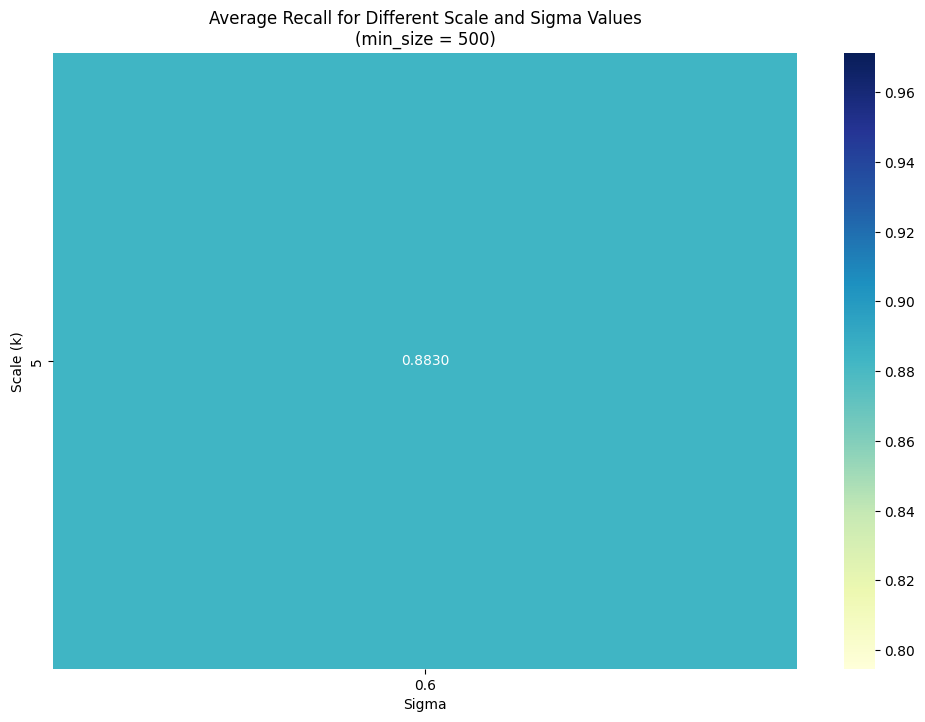

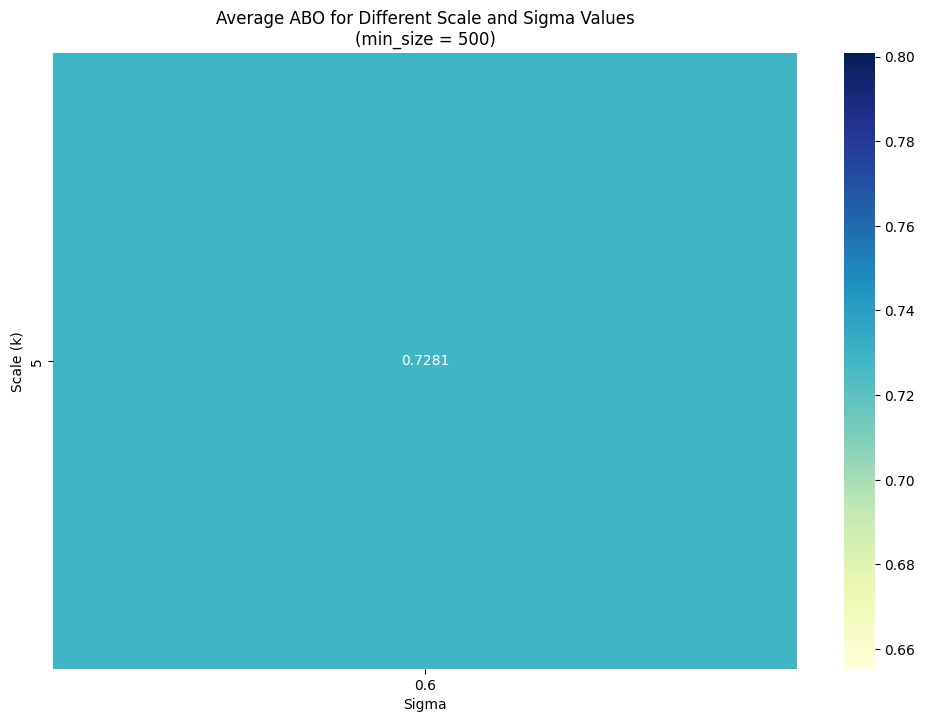

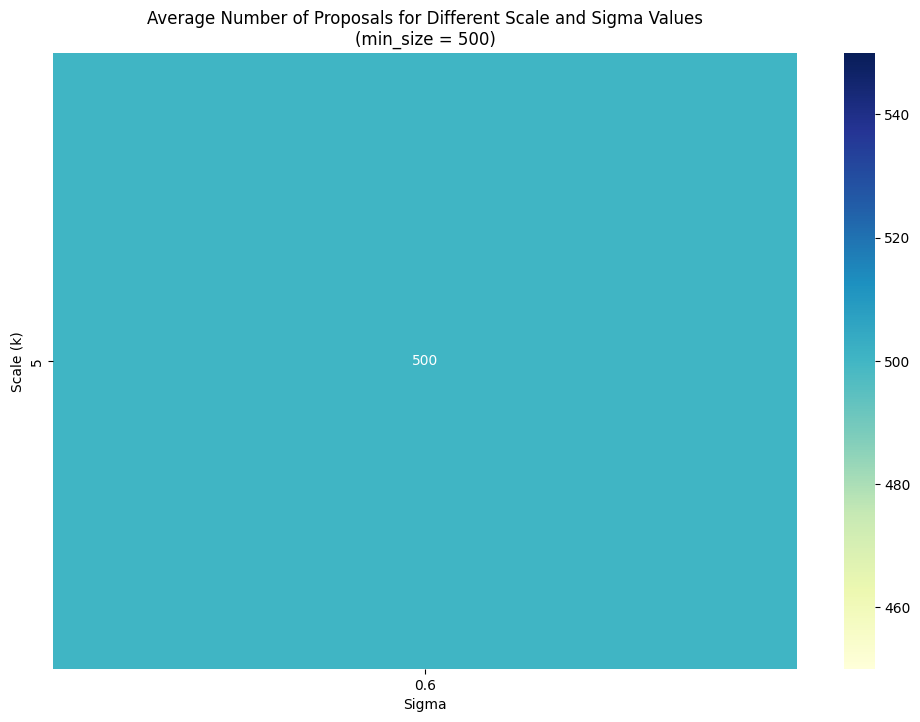

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for plotting or analysis
data = []
for (k, sigma, min_size) in results.keys():
    avg_props = average_num_proposals[(k, sigma, min_size)]
    avg_recall = average_recalls[(k, sigma, min_size)]
    avg_abo = average_abos[(k, sigma, min_size)]
    data.append({
        'Scale (k)': k,
        'Sigma': sigma,
        'Min_Size': min_size,
        'Avg Proposals': avg_props,
        'Avg Recall': avg_recall,
        'Avg ABO': avg_abo
    })

df = pd.DataFrame(data)

# Get the list of unique min_size values
min_size_values = df['Min_Size'].unique()

# Plot heatmaps for each min_size value
for min_size in min_size_values:
    # Filter the DataFrame for the current min_size
    df_min_size = df[df['Min_Size'] == min_size]
    
    # Pivot the DataFrame to create matrices for heatmaps
    recall_pivot = df_min_size.pivot(index='Scale (k)', columns='Sigma', values='Avg Recall')
    abo_pivot = df_min_size.pivot(index='Scale (k)', columns='Sigma', values='Avg ABO')
    proposals_pivot = df_min_size.pivot(index='Scale (k)', columns='Sigma', values='Avg Proposals')
    
    # Plot heatmap for Average Recall
    plt.figure(figsize=(12, 8))
    sns.heatmap(recall_pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f'Average Recall for Different Scale and Sigma Values\n(min_size = {min_size})')
    plt.xlabel('Sigma')
    plt.ylabel('Scale (k)')
    plt.show()
    
    # Plot heatmap for Average ABO
    plt.figure(figsize=(12, 8))
    sns.heatmap(abo_pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f'Average ABO for Different Scale and Sigma Values\n(min_size = {min_size})')
    plt.xlabel('Sigma')
    plt.ylabel('Scale (k)')
    plt.show()
    
    # Plot heatmap for Average Number of Proposals
    plt.figure(figsize=(12, 8))
    sns.heatmap(proposals_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f'Average Number of Proposals for Different Scale and Sigma Values\n(min_size = {min_size})')
    plt.xlabel('Sigma')
    plt.ylabel('Scale (k)')
    plt.show()


In [32]:
np.logspace(0,4, 40)

array([1.00000000e+00, 1.26638017e+00, 1.60371874e+00, 2.03091762e+00,
       2.57191381e+00, 3.25702066e+00, 4.12462638e+00, 5.22334507e+00,
       6.61474064e+00, 8.37677640e+00, 1.06081836e+01, 1.34339933e+01,
       1.70125428e+01, 2.15443469e+01, 2.72833338e+01, 3.45510729e+01,
       4.37547938e+01, 5.54102033e+01, 7.01703829e+01, 8.88623816e+01,
       1.12533558e+02, 1.42510267e+02, 1.80472177e+02, 2.28546386e+02,
       2.89426612e+02, 3.66524124e+02, 4.64158883e+02, 5.87801607e+02,
       7.44380301e+02, 9.42668455e+02, 1.19377664e+03, 1.51177507e+03,
       1.91448198e+03, 2.42446202e+03, 3.07029063e+03, 3.88815518e+03,
       4.92388263e+03, 6.23550734e+03, 7.89652287e+03, 1.00000000e+04])

In [23]:

space = np.linspace(10, 1500, 30)

# convert space to int
space = space.astype(int)


scale = 5
sigma = 0.6
min_size = 200


num_images = 40
# Prepare proposals for the current k, sigma, and min_size
proposal_data, labels = prepare_proposals(
                images_path=img_path,
                annotations_path=anno_path,
                proposals_per_image=5000,
                iou_threshold=0.5,
                scale=scale,  # Use 'k' instead of 'scale'
                sigma=sigma,
                min_size=min_size,
                image_shape=(TARGET_HEIGHT, TARGET_WIDTH),
                count=num_images
            )



import matplotlib.pyplot as plt

# Initialize dictionaries to store the sum of recall and abo for each count
recall_sum = {count: 0 for count in space}
abo_sum = {count: 0 for count in space}

# Initialize dictionaries to store the average recall and abo for each count
recall_avg = {count: 0 for count in space}
abo_avg = {count: 0 for count in space}

# Process each count
for count in space:
    # Process each image to calculate recall and ABO
    for i in range(num_images):
        # Get the proposals and labels for this image
        proposals = proposal_data[i]  # List of proposals (x, y, w, h)

        # Get the corresponding image and annotation filenames
        img_name = os.path.join(img_path, image_paths[i])
        label_name = os.path.join(anno_path, label_paths[i])

        image = cv2.imread(img_name)

        original_height, original_width = image.shape[:2]
        height_ratio = TARGET_HEIGHT / original_height
        width_ratio = TARGET_WIDTH / original_width

        # Load and resize ground truth boxes
        ground_truth_boxes = parse_xml(label_name)  # Returns boxes in (xmin, ymin, xmax, ymax) format
        ground_truth_boxes = [
            (
                int(xmin * width_ratio),
                int(ymin * height_ratio),
                int(xmax * width_ratio),
                int(ymax * height_ratio)
            )
            for (xmin, ymin, xmax, ymax) in ground_truth_boxes
        ]

        prop = proposals[:count]

        # Calculate ABO and recall
        abo = calc_abo(prop, ground_truth_boxes)
        recall = calc_recall(prop, ground_truth_boxes, iou_threshold=0.5)

        # Update the sum of recall and abo
        recall_sum[count] += recall
        abo_sum[count] += abo

    # Calculate the average recall and abo for the current count
    recall_avg[count] = recall_sum[count] / num_images
    abo_avg[count] = abo_sum[count] / num_images


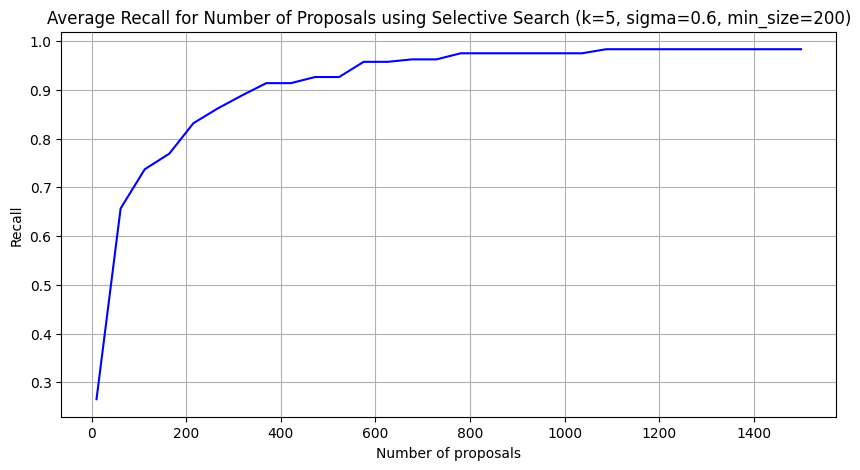

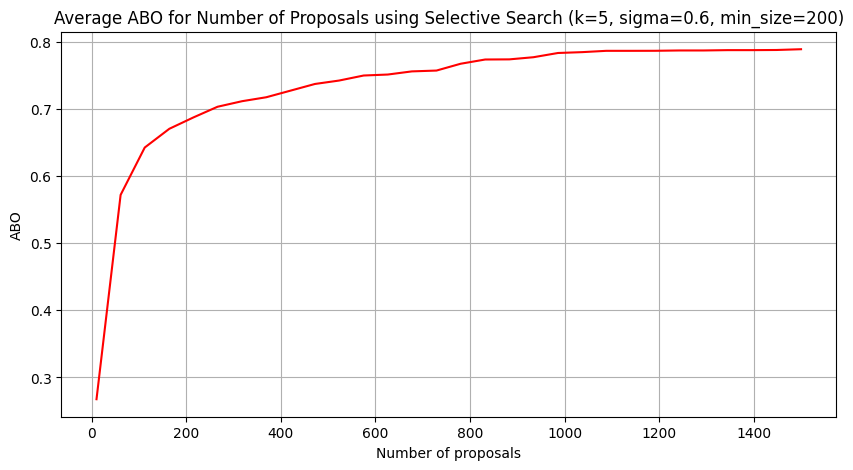

In [27]:

# Plot for Recall
plt.figure(figsize=(10, 5))
plt.plot(space, list(recall_avg.values()), linestyle='-', color='b')
plt.title('Average Recall for Number of Proposals using Selective Search (k=5, sigma=0.6, min_size=200)')
plt.xlabel('Number of proposals')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

# Plot for ABO
plt.figure(figsize=(10, 5))
plt.plot(space, list(abo_avg.values()), linestyle='-', color='r')
plt.title('Average ABO for Number of Proposals using Selective Search (k=5, sigma=0.6, min_size=200)')
plt.xlabel('Number of proposals')
plt.ylabel('ABO')
plt.grid(True)
plt.show()